## Indexing
1. First we need to load our data. This is done with Document Loaders
2. Split: Text splitters break large documents into smaller chunks. This is useful both for indexing data and passing it in a model, as large chunks are harder to search over and won't fit in a model's context window.
3. Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done via vector store and embedding model.

## Retrieval and generation
4. Retrieve: Given a user input, relevant splits are retrieved from storage using retriever
5. Generate: A chatmodel/LLM produces an answer using a prompt that includes both the questions with the retrieved data.

In [1]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/Users/dhruvgarg/miniforge3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

In [4]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

#Only keep post-title, headers and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(
    class_ = ("post-title", "post-header","post-content"))

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")


Total characters: 43047


In [6]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


# Splitting Documents

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000, # chunk size (characters)
    chunk_overlap = 200, # chunk overlap (characters)
    add_start_index = True # track index in original document
)

all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [8]:
document_ids = vector_store.add_documents(
    documents = all_splits
)

In [9]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/dhruvgarg/miniforge3/envs/test_env/lib/python3.10/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [10]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [11]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [14]:
from langgraph.graph import START, StateGraph
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

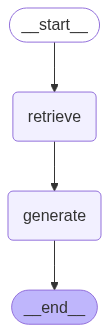

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

PermissionDeniedError: Error code: 403 - {'error': {'message': 'Project `proj_EKd7bNI08ibIwHEVYCaAgOGE` does not have access to model `gpt-4o-mini`', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}